<a href="https://colab.research.google.com/github/Elena-Gauci/Hornet-Detection/blob/main/YOLOv11mVSb8n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf Hornet-Detection
!git clone https://github.com/Elena-Gauci/Hornet-Detection.git
%cd Hornet-Detection
!ls

Cloning into 'Hornet-Detection'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 3), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 91.90 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/Hornet-Detection
Preprocessing.ipynb  yolov8_train_colab.ipynb
README.md	     YOLOv8_vs_YOLOV11.ipynb


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!rsync -a \
  --include="*/" \
  --include="*.jpg" \
  --include="*.txt" \
  --include="*.yaml" \
  --exclude="*" \
  /content/drive/MyDrive/hornet_detection/ \
  /content/hornet_detection/

In [4]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.7 MB/s eta 0:00:00


In [5]:
from ultralytics import YOLO
from sklearn.model_selection import KFold
from pathlib import Path
import yaml
import numpy as np
import itertools
import random
import json
import os
import time
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from ultralytics.utils.metrics import bbox_iou
os.environ["YOLO_CACHE"] = "False"

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
!find /content/drive/MyDrive/hornet_detection -name "*.cache" -delete

In [7]:
from pathlib import Path

data_yaml = Path("data.yaml")

data_yaml.write_text(
"""path: /content/hornet_detection/Occlusion-Test-5-bbox
train: train/images
val: valid/images

nc: 3
names:
  0: bee
  1: hornet
  2: other
"""
)

138

In [8]:
BASE_DATA_YAML = str(Path("data.yaml").resolve())

with open(BASE_DATA_YAML) as f:
    base_data = yaml.safe_load(f)

DATA_ROOT = Path(base_data["path"])
ALL_IMAGES_DIR = DATA_ROOT / "train/images"

ALL_IMAGES = sorted(ALL_IMAGES_DIR.glob("*.jpg"))
assert len(ALL_IMAGES) > 0, "No images found"

In [9]:
N_TRIALS = 1              # deliberately small (critical)
IMG_SIZE = 960
EPOCHS = 200
PATIENCE = 30
SEED = 42

MODELS = ["yolo11m.pt", "yolov8n.pt"]

In [15]:
#SEARCH_SPACE = {
#    "lr0": [1e-4, 3e-4, 1e-3], #learning rate
#    "batch": [4, 8], # batch size
#    "weight_decay": [1e-5, 1e-4, 5e-4], # L2 regularisation applied to the model’s weights during optimisation, it adds a penalty term to the loss
#    use scale as we are scaling the object not the image
#}

SEARCH_SPACE = {
    "lr0": [0.01],#learning rate
    "batch": [8], # batch size
    "weight_decay": [5e-4], # L2 regularisation applied to the model’s weights during optimisation, it adds a penalty term to the loss
}

In [9]:
def sample_params(space):
    return {k: random.choice(v) for k, v in space.items()}

def format_run_name(model_name, params):
    lr = params["lr0"]
    batch = params["batch"]
    wd = params["weight_decay"]

    lr_str = f"{lr:.0e}".replace("-", "")
    wd_str = f"{wd:.0e}".replace("-", "")

    return f"{model_name}_{lr_str}_{batch}_{wd_str}"

In [17]:
# -----------------------
# Train + validate
# -----------------------
def train_eval(model_name, params, trial_id):
    model = YOLO(model_name)

    run_name = f"{format_run_name(model_name, params)}_trial{trial_id}"
    run_dir = f"{DRIVE_RUNS_DIR}/{run_name}"
    last_ckpt = f"{run_dir}/weights/last.pt"

    resume = os.path.exists(last_ckpt)

    if resume:
        print(f"Resuming training from {last_ckpt}")
    else:
        print(f"Starting fresh run: {run_name}")

    # -----------------------
    # Train
    # -----------------------
    train_start = time.perf_counter()

    model.train(
        data=str(Path("data.yaml").resolve()),
        imgsz=IMG_SIZE,
        epochs=EPOCHS,
        patience=PATIENCE,
        optimizer="AdamW",
        cache=False,
        workers=2,
        seed=SEED + trial_id,   # decorrelate trials
        verbose=False,

        project=DRIVE_RUNS_DIR,
        name=run_name,
        exist_ok=True,
        resume=resume,

        **params
    )

    train_end = time.perf_counter()
    train_time = train_end - train_start

    print(f"[Trial {trial_id}] Training time: {train_time:.2f} seconds")

    # -----------------------
    # Reload best weights
    # -----------------------
    best_model = YOLO(f"{run_dir}/weights/best.pt")

    # -----------------------
    # Validation (diagnostics-safe)
    # -----------------------
    val_start = time.perf_counter()

    metrics = best_model.val(
        data=str(Path("data.yaml").resolve()),
        split="val",
        conf=0.01,
        iou=0.7,
        save_json=True,
        project=DRIVE_RUNS_DIR,
        name=f"{run_name}_val",
        cache=False,
        workers=2,
        verbose=False
    )

    val_end = time.perf_counter()
    val_time = val_end - val_start

    total_time = train_time + val_time

    print(
        f"[Trial {trial_id}] "
        f"Validation time: {val_time:.2f}s | "
        f"Total time: {total_time:.2f}s"
    )

    return metrics.box.map50

In [10]:
DRIVE_RUNS_DIR = "/content/drive/MyDrive/hornet_detection/occlusion-test/runs"

In [18]:
# -----------------------
# Main experiment loop
# -----------------------
results = {m: [] for m in MODELS}

for model_name in MODELS:
    print(f"\n=== Evaluating {model_name} ===")

    best_score = -1
    best_params = None

    for trial in range(N_TRIALS):
        params = sample_params(SEARCH_SPACE)
        print(f" Trial {trial + 1}/{N_TRIALS}: {params}")

        score = train_eval(model_name, params, trial)

        if score > best_score:
            best_score = score
            best_params = params

    print(f" Best mAP50 for {model_name}: {best_score:.4f}")
    results[model_name].append(best_score)


=== Evaluating yolo11m.pt ===
 Trial 1/1: {'lr0': 0.01, 'batch': 8, 'weight_decay': 0.0005}
Starting fresh run: yolo11m.pt_1e02_8_5e04_trial0
Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Hornet-Detection/Hornet-Detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937,

In [37]:
def compare_curves(curve_name):
    train_path = Path(DRIVE_RUNS_DIR) / run_name / curve_name
    val_path   = Path(DRIVE_RUNS_DIR) / f"{run_name}_val" / curve_name

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].imshow(Image.open(train_path))
    ax[0].set_title(f"Training {curve_name}")
    ax[0].axis("off")

    ax[1].imshow(Image.open(val_path))
    ax[1].set_title(f"Validation {curve_name}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()


# YOLO 11m Metrics

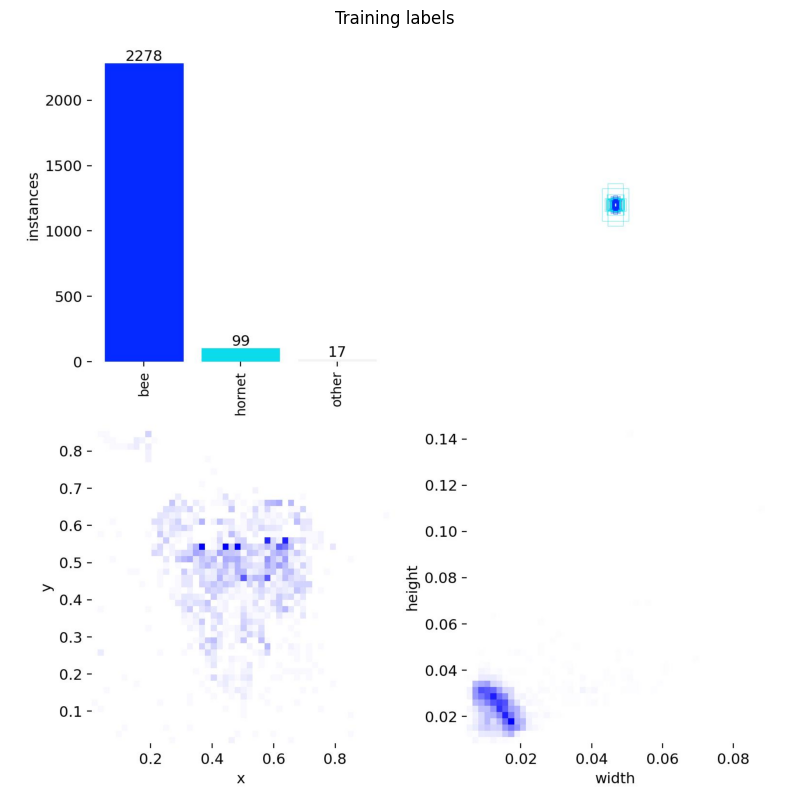

In [62]:
run_name = "yolo11m.pt_1e02_8_5e04_trial0"

train_path = Path(DRIVE_RUNS_DIR) / run_name / "labels.jpg"

img = Image.open(train_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title("Training labels")
plt.axis("off")
plt.show()

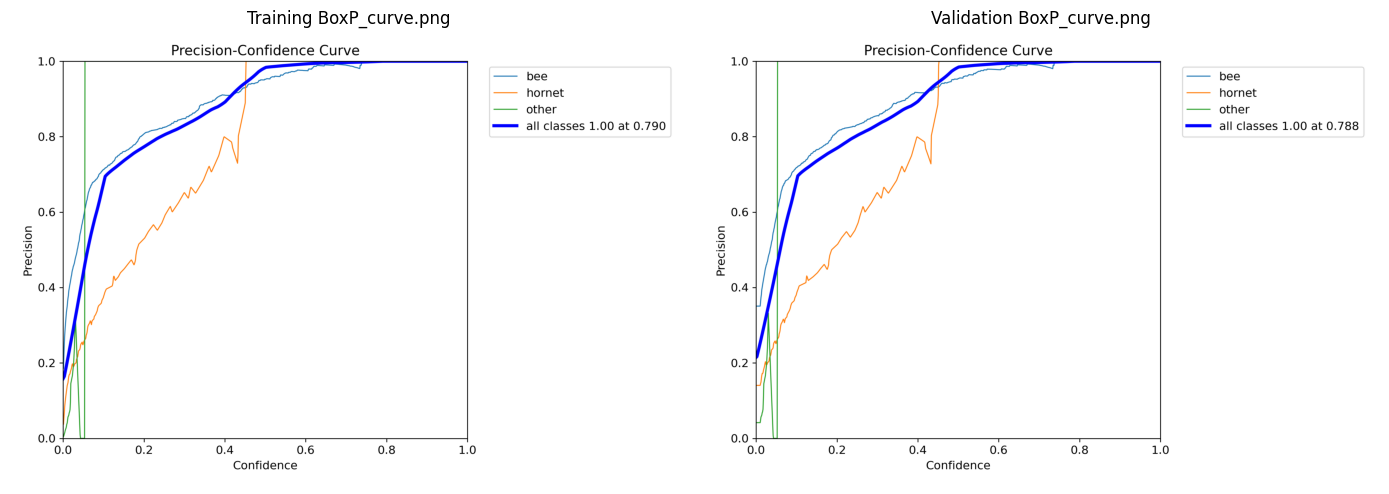

In [39]:
compare_curves("BoxP_curve.png")

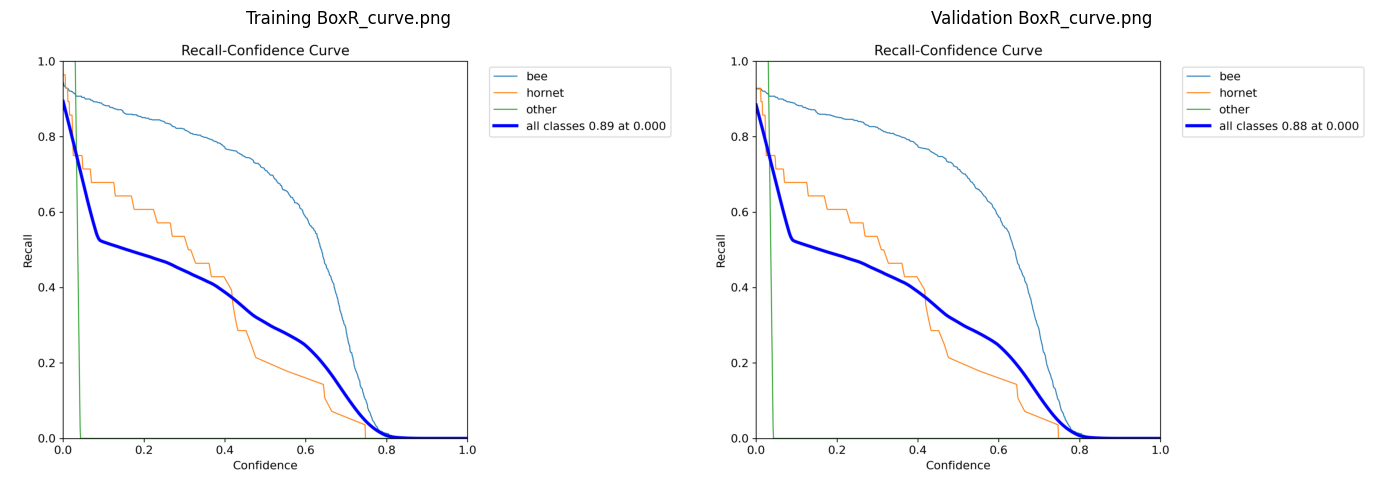

In [40]:
compare_curves("BoxR_curve.png")

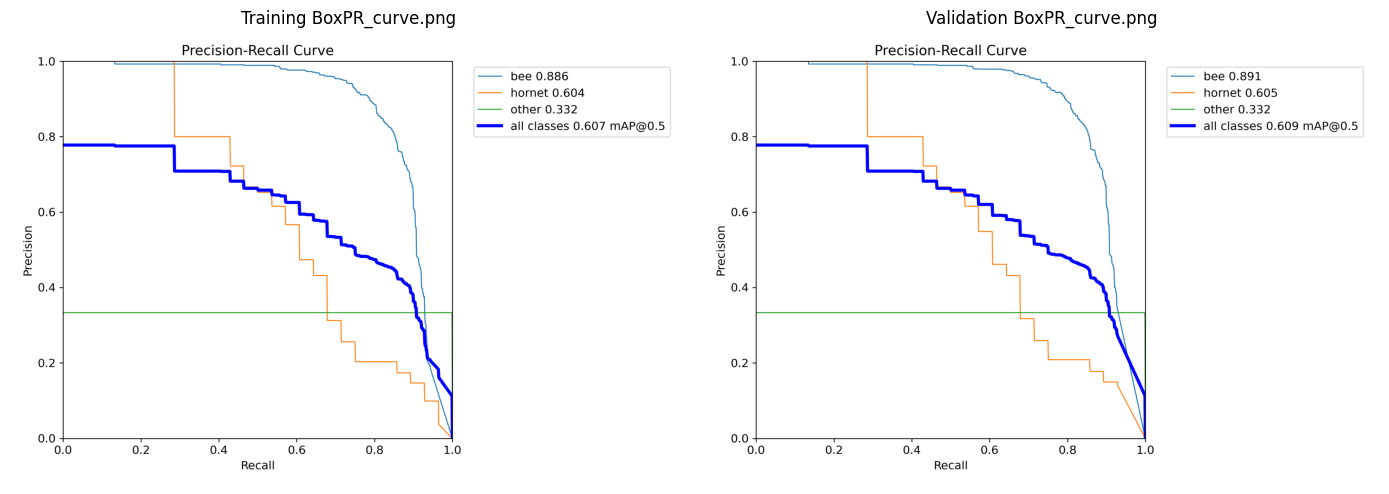

In [41]:
compare_curves("BoxPR_curve.png")

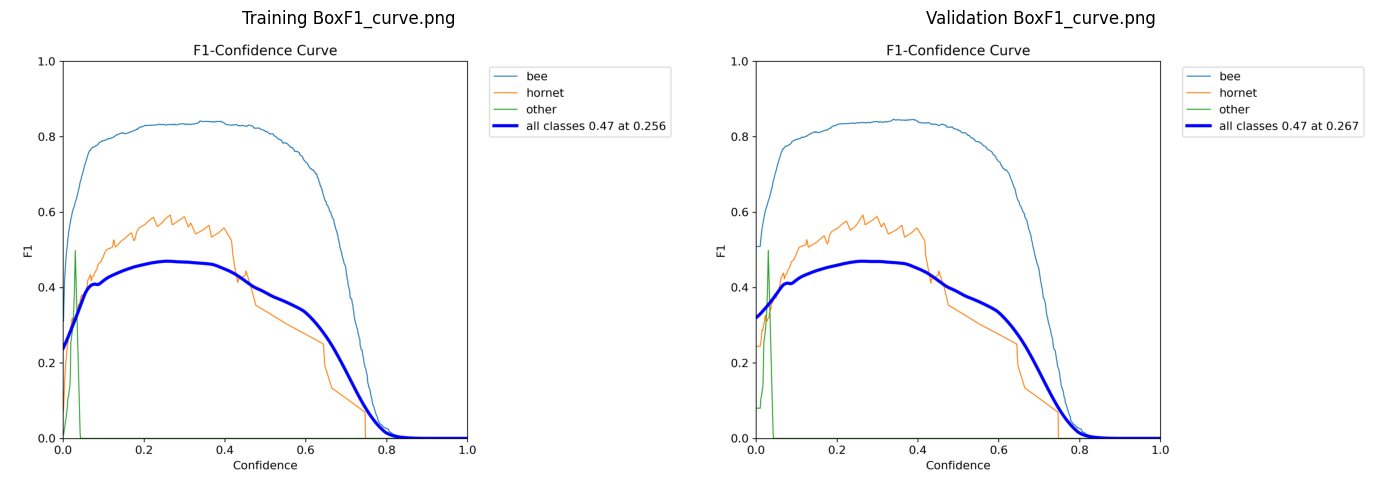

In [42]:
compare_curves("BoxF1_curve.png")

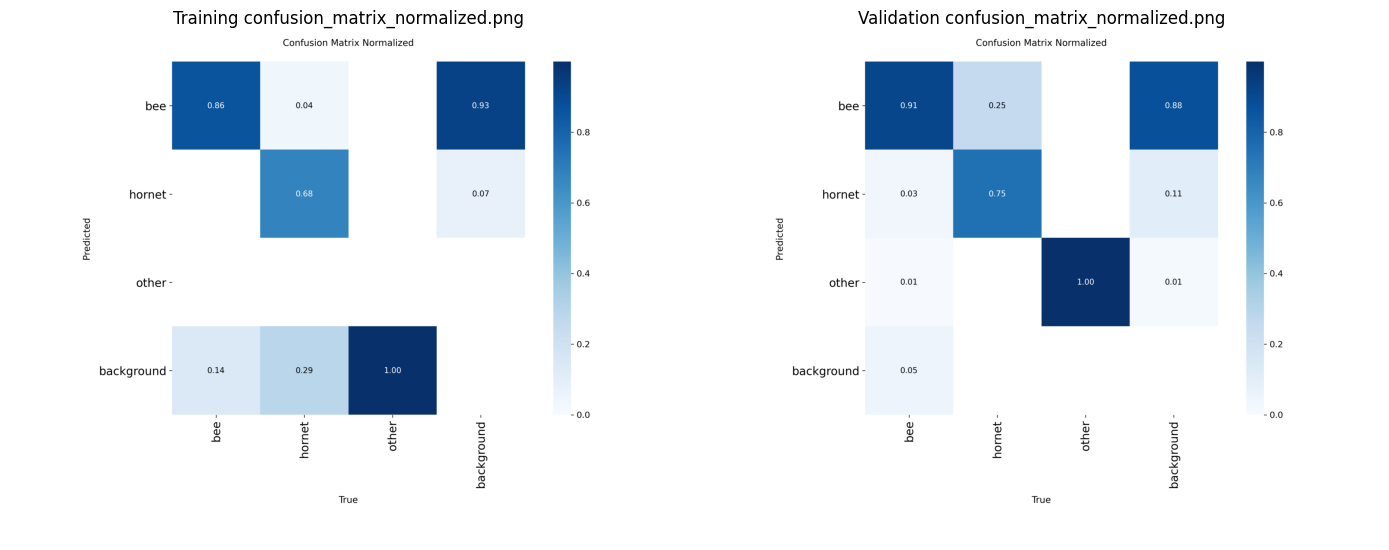

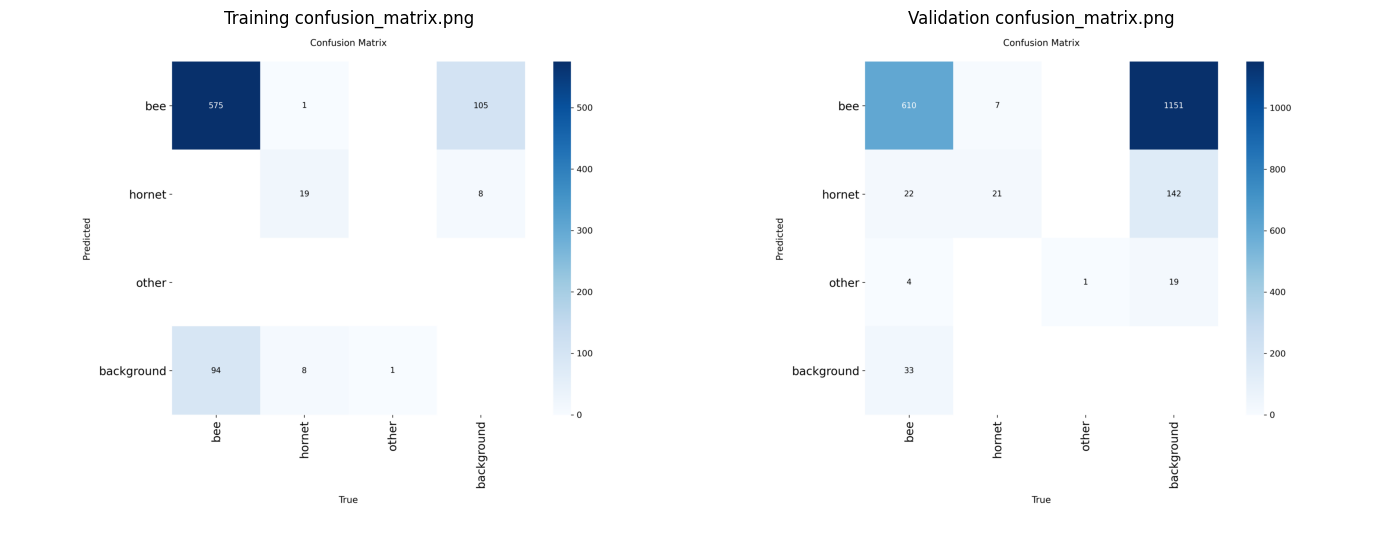

In [43]:
compare_curves("confusion_matrix_normalized.png")
compare_curves("confusion_matrix.png")

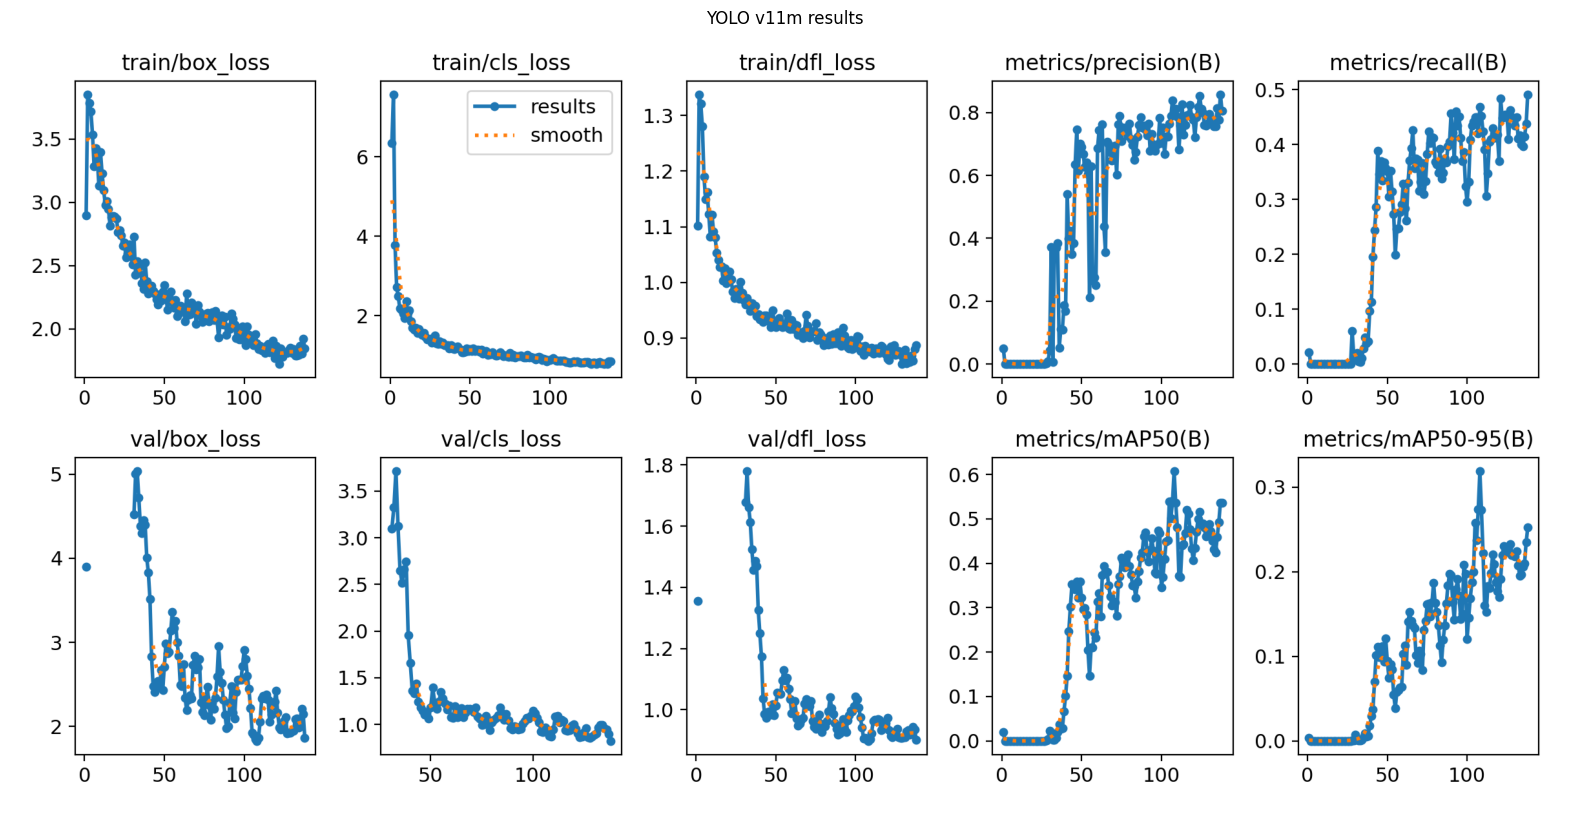

In [63]:
results_path = Path(DRIVE_RUNS_DIR) / run_name / "results.png"

img = Image.open(results_path)

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.title("YOLO v11m results")
plt.axis("off")
plt.show()

# YOLO v8 metrics

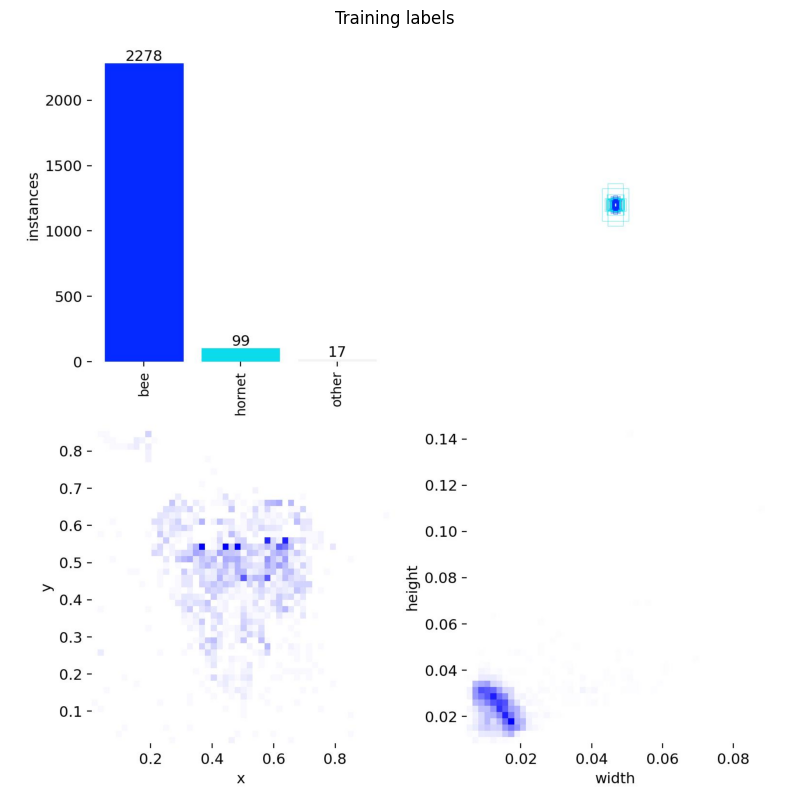

In [64]:
run_name = "yolov8n.pt_1e02_8_5e04_trial0"

train_path = Path(DRIVE_RUNS_DIR) / run_name / "labels.jpg"

img = Image.open(train_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title("Training labels")
plt.axis("off")
plt.show()


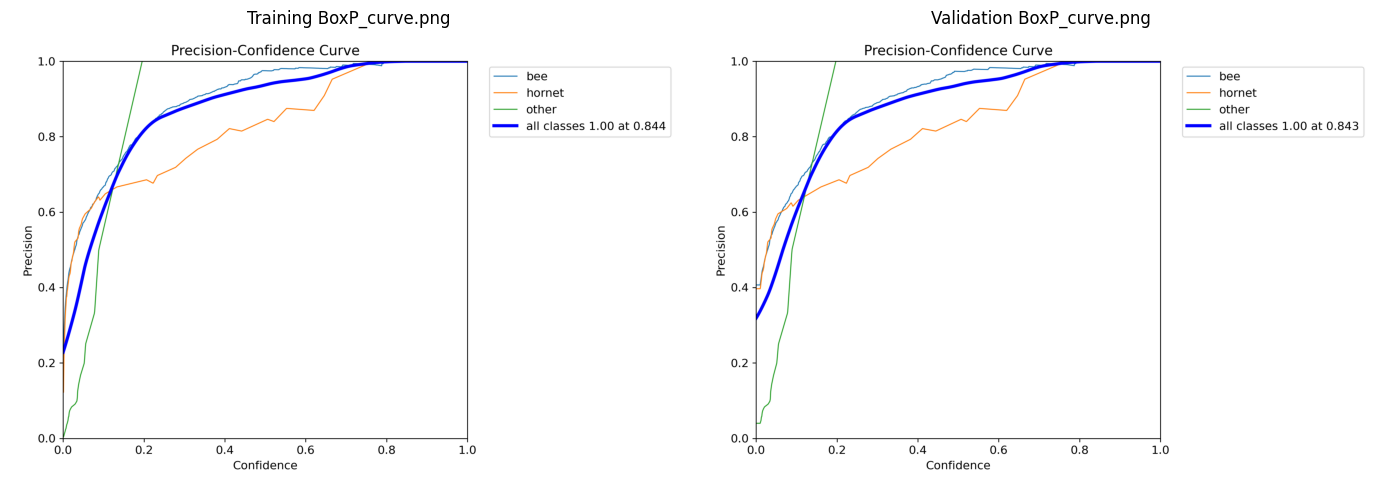

In [46]:
compare_curves("BoxP_curve.png")

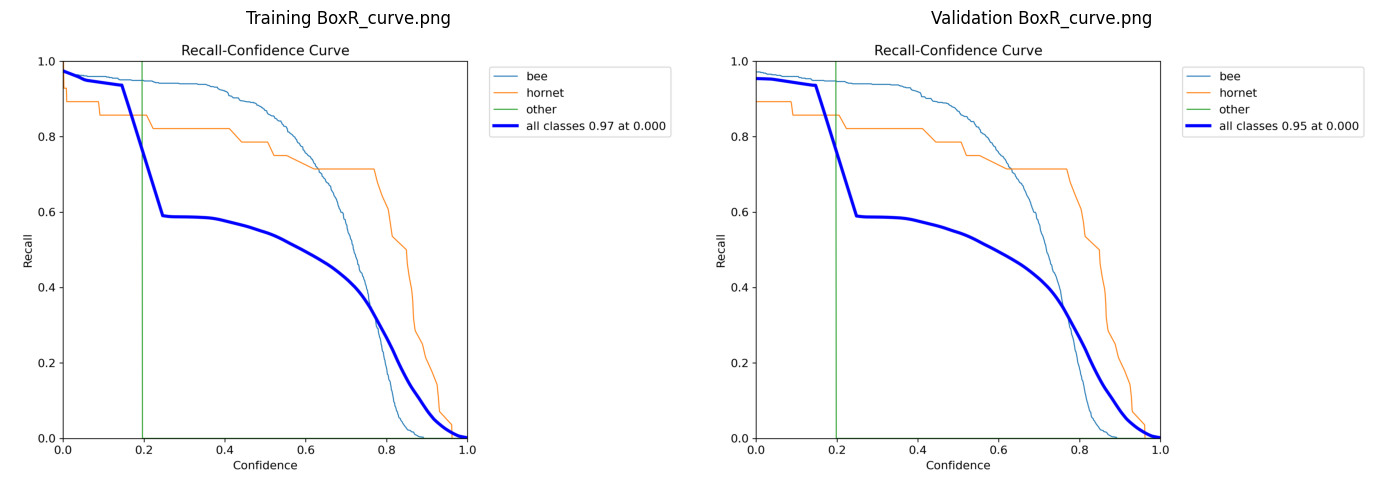

In [47]:
compare_curves("BoxR_curve.png")

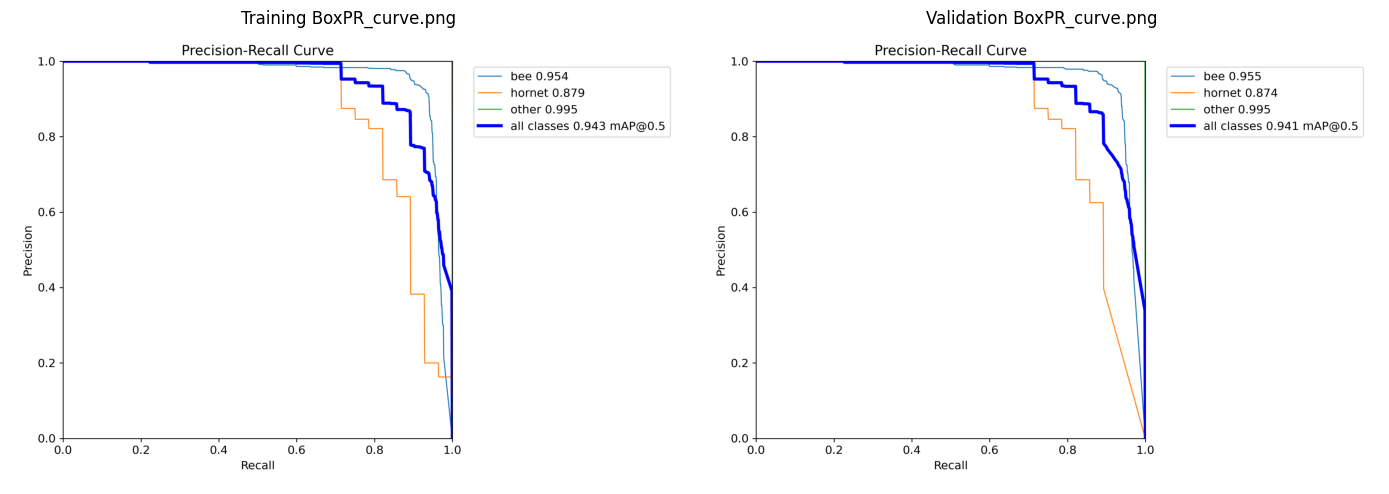

In [48]:
compare_curves("BoxPR_curve.png")

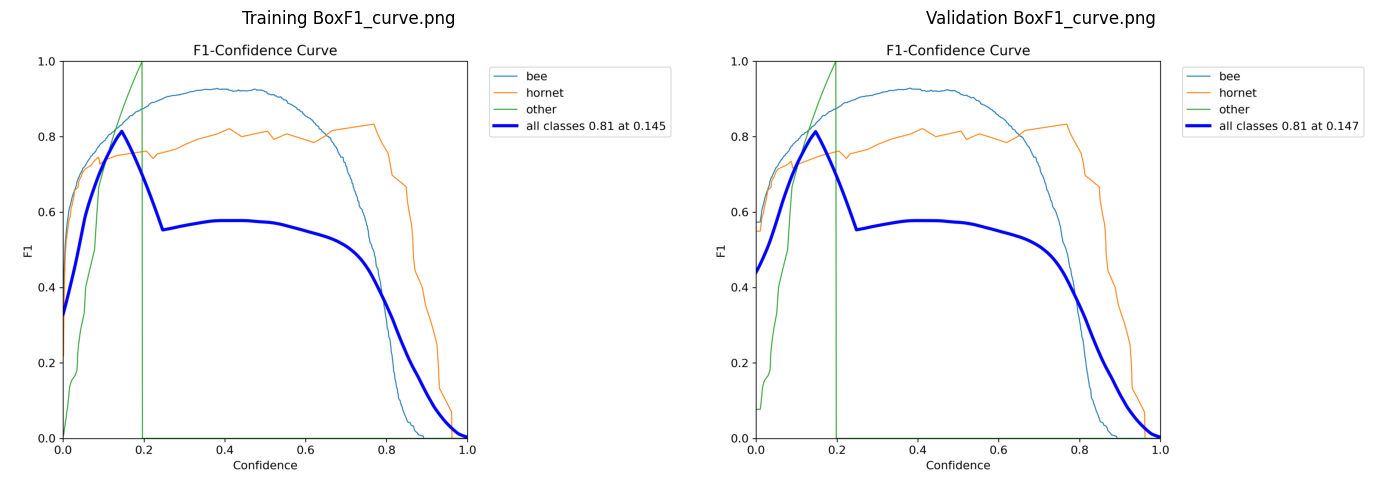

In [49]:
compare_curves("BoxF1_curve.png")

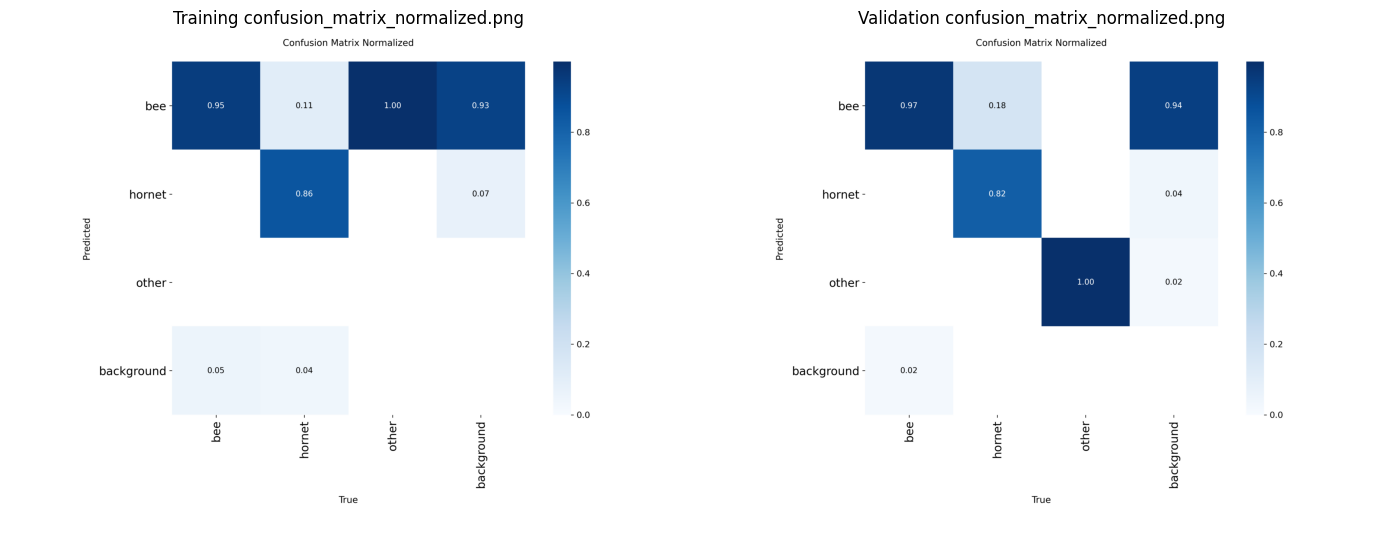

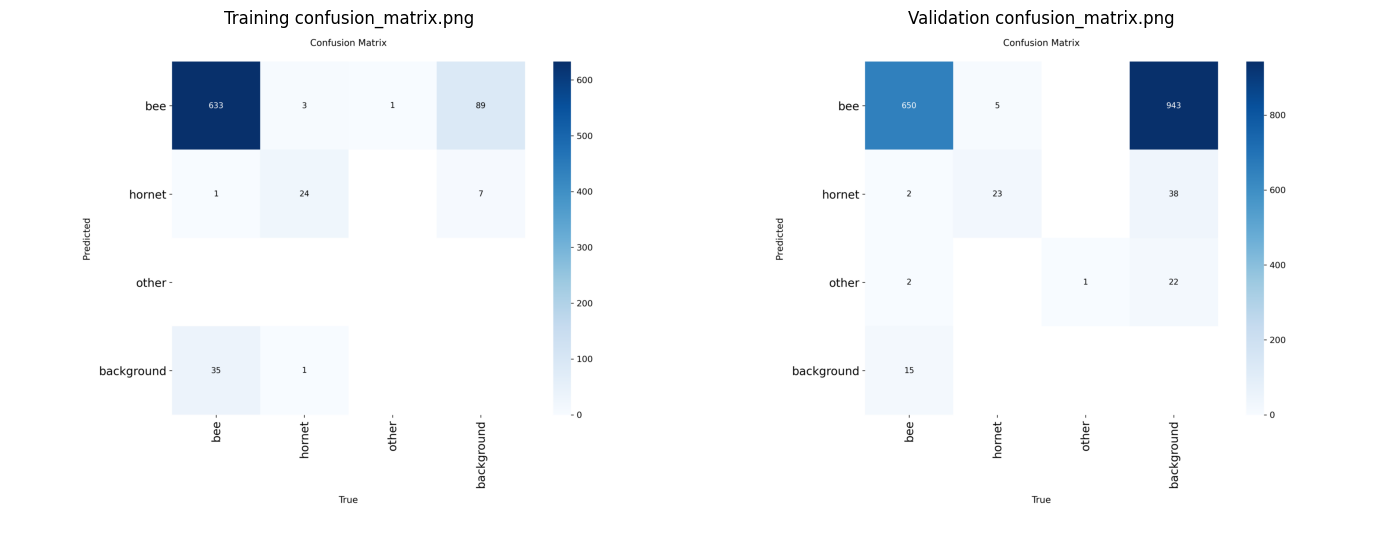

In [50]:
compare_curves("confusion_matrix_normalized.png")
compare_curves("confusion_matrix.png")

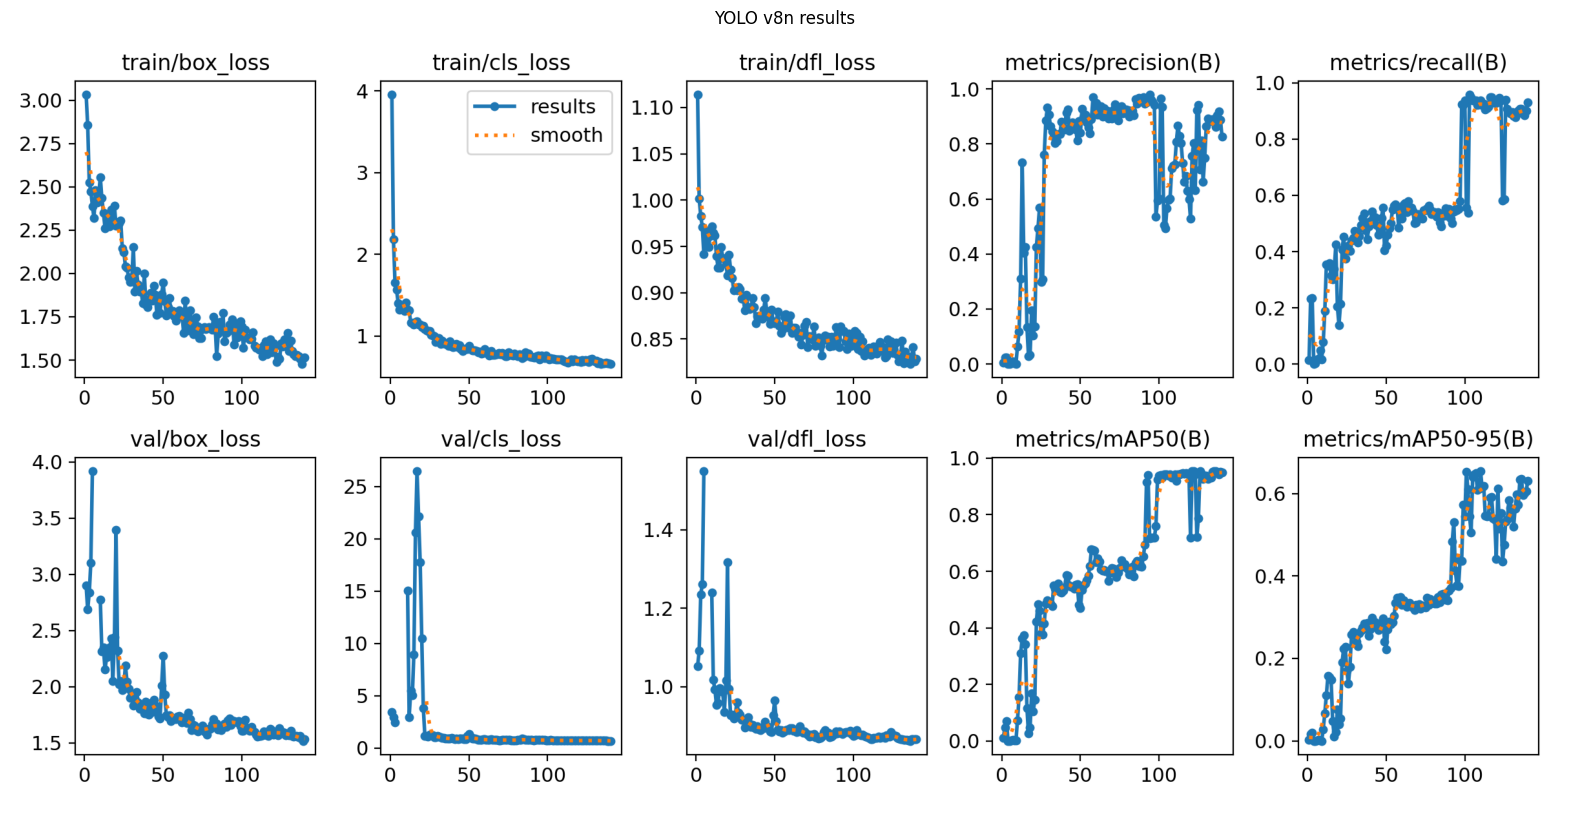

In [65]:
results_path = Path(DRIVE_RUNS_DIR) / run_name / "results.png"

img = Image.open(results_path)

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.title("YOLO v8n results")
plt.axis("off")
plt.show()

# ECE and Reliability Diagrams

ECE and reliability curves come from probabilistic calibration theory. They answer a different question from F1 / mAP:

“When the model says 80% confidence, is it actually correct ~80% of the time?”

**Reliability curve (a.k.a. calibration curve)**

A reliability curve plots:

x-axis: predicted confidence (binned, e.g. 0.0–0.1, 0.1–0.2, …)

y-axis: empirical accuracy (or precision) in that bin

You also plot the identity line y = x, which represents perfect calibration.

**How to read it**

Curve on the diagonal → well calibrated

Curve below diagonal → overconfident

Curve above diagonal → underconfident

In [52]:
def bbox_iou_np(box1, box2):
    # box1, box2: xyxy in pixels
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    inter_x1 = max(x1, x1g)
    inter_y1 = max(y1, y1g)
    inter_x2 = min(x2, x2g)
    inter_y2 = min(y2, y2g)

    inter = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x2g - x1g) * (y2g - y1g)

    union = area1 + area2 - inter
    return inter / union if union > 0 else 0.0


In [53]:
def collect_calibration_data(
    model,
    images_dir,
    labels_dir,
    iou_thresh=0.5
):
    cal_data = {
        cls_id: {"conf": [], "correct": []}
        for cls_id in model.names.keys()
    }

    image_paths = sorted(Path(images_dir).glob("*.*"))

    for img_path in image_paths:
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        h, w = img.shape[:2]

        label_path = Path(labels_dir) / f"{img_path.stem}.txt"
        if not label_path.exists():
            continue

        gts = np.loadtxt(label_path).reshape(-1, 5)

        # Convert GT boxes to pixel xyxy
        gt_boxes = []
        for gt in gts:
            cls, cx, cy, bw, bh = gt
            cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h
            x1 = cx - bw / 2
            y1 = cy - bh / 2
            x2 = cx + bw / 2
            y2 = cy + bh / 2
            gt_boxes.append((int(cls), [x1, y1, x2, y2]))

        results = model.predict(img, conf=0.001, verbose=False)[0]

        # Sort predictions by confidence (descending)
        preds = sorted(
            zip(
                results.boxes.xyxy.cpu().numpy(),
                results.boxes.cls.cpu().numpy().astype(int),
                results.boxes.conf.cpu().numpy()
            ),
            key=lambda x: -x[2]
        )

        matched_gt = set()

        for box, cls, conf in preds:
            is_tp = 0
            for i, (gt_cls, gt_box) in enumerate(gt_boxes):
                if i in matched_gt:
                    continue
                if gt_cls == cls and bbox_iou_np(box, gt_box) >= iou_thresh:
                    is_tp = 1
                    matched_gt.add(i)
                    break

            cal_data[cls]["conf"].append(float(conf))
            cal_data[cls]["correct"].append(is_tp)

    return cal_data


In [54]:
def compute_ece(confidences, correctness, n_bins=10):
    confidences = np.asarray(confidences)
    correctness = np.asarray(correctness)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    n = len(confidences)

    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i + 1])
        if np.any(mask):
            acc = np.mean(correctness[mask])
            conf = np.mean(confidences[mask])
            ece += (np.sum(mask) / n) * abs(acc - conf)

    return ece



In [55]:
def reliability_curve(confidences, correctness, n_bins=10):
    confidences = np.asarray(confidences)
    correctness = np.asarray(correctness)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers, accs = [], []

    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i + 1])
        if np.any(mask):
            bin_centers.append((bins[i] + bins[i + 1]) / 2)
            accs.append(np.mean(correctness[mask]))

    return np.array(bin_centers), np.array(accs)


In [56]:
def plot_classwise_reliability(cal_data, class_names, n_bins=10):
    plt.figure(figsize=(7, 7))

    for cls_id, data in cal_data.items():
        if len(data["conf"]) == 0:
            continue

        x, acc = reliability_curve(
            data["conf"],
            data["correct"],
            n_bins=n_bins
        )

        plt.plot(x, acc, marker="o", label=class_names[cls_id])

    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
    plt.xlabel("Confidence")
    plt.ylabel("Empirical accuracy")
    plt.title("Class-wise Reliability Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [57]:
model = YOLO("/content/drive/MyDrive/hornet_detection/occlusion-test/"
    "runs/yolo11m.pt_1e02_8_5e04_trial0/weights/best.pt")

cal_data = collect_calibration_data(
    model,
    images_dir="/content/hornet_detection/Occlusion-Test-5-bbox/valid/images",
    labels_dir="/content/hornet_detection/Occlusion-Test-5-bbox/valid/labels",
    iou_thresh=0.5
)

for k, v in cal_data.items():
    print(model.names[k], len(v["conf"]), "detections")




bee 3604 detections
hornet 319 detections
other 21 detections


bee: ECE = 0.0470
hornet: ECE = 0.0292
other: ECE = 0.0069


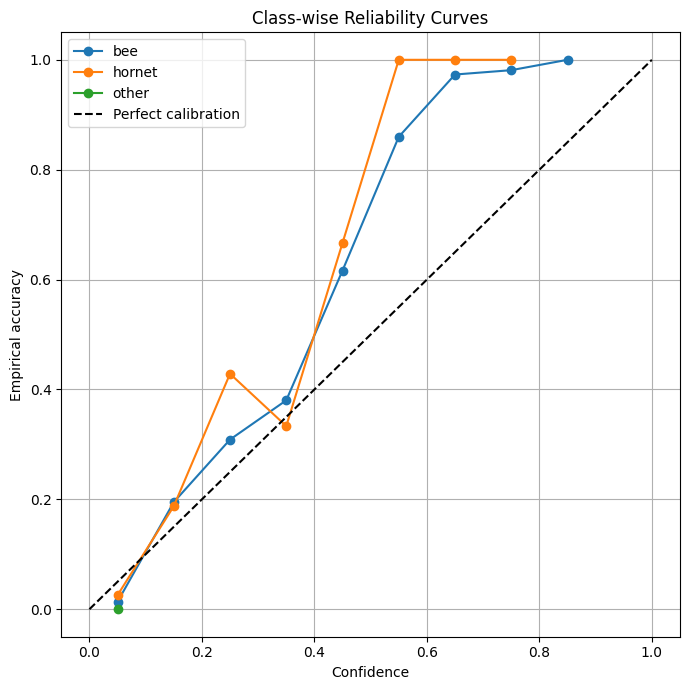

In [58]:
for cls_id, data in cal_data.items():
    if len(data["conf"]) > 0:
        ece = compute_ece(data["conf"], data["correct"])
        print(f"{model.names[cls_id]}: ECE = {ece:.4f}")

plot_classwise_reliability(
    cal_data,
    model.names,
    n_bins=10
)

In [59]:
model = YOLO("/content/drive/MyDrive/hornet_detection/occlusion-test/"
    "runs/yolov8n.pt_1e02_8_5e04_trial0/weights/best.pt")

cal_data = collect_calibration_data(
    model,
    images_dir="/content/hornet_detection/Occlusion-Test-5-bbox/valid/images",
    labels_dir="/content/hornet_detection/Occlusion-Test-5-bbox/valid/labels",
    iou_thresh=0.5
)

for k, v in cal_data.items():
    print(model.names[k], len(v["conf"]), "detections")

bee 3014 detections
hornet 122 detections
other 65 detections


bee: ECE = 0.0687
hornet: ECE = 0.0602
other: ECE = 0.0068


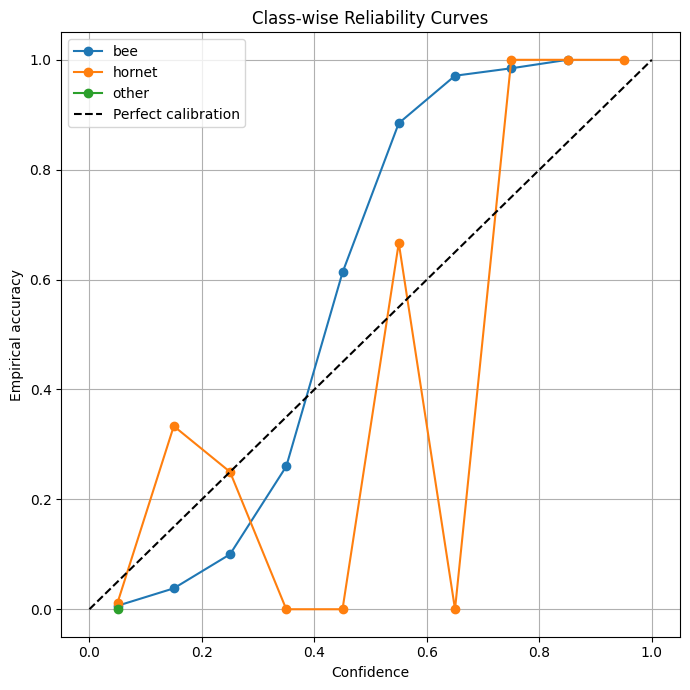

In [60]:
for cls_id, data in cal_data.items():
    if len(data["conf"]) > 0:
        ece = compute_ece(data["conf"], data["correct"])
        print(f"{model.names[cls_id]}: ECE = {ece:.4f}")

plot_classwise_reliability(
    cal_data,
    model.names,
    n_bins=10
)

Number of detections: 25
Confidences: [    0.82174     0.81217     0.77449     0.77059     0.75262     0.75162     0.74768     0.73864     0.73383      0.7048]
Classes: [          0           0           0           0           0           0           0           0           0           0]


(np.float64(-0.5), np.float64(5311.5), np.float64(2987.5), np.float64(-0.5))

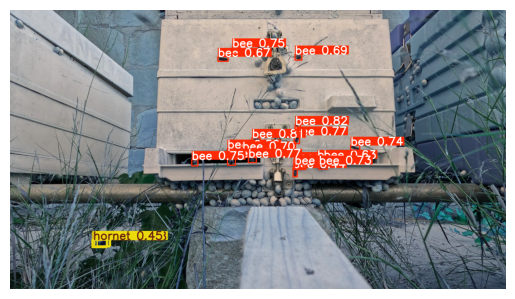

In [61]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO("/content/drive/MyDrive/hornet_detection/occlusion-test/"
    "runs/yolo11m.pt_1e02_8_5e04_trial0/weights/best.pt")

img_path = "/content/hornet_detection/Occlusion-Test-5-bbox/valid/images/GX010019_00-01-05_00-01-10_frame_000054_jpg.rf.c760adfd2af0555345827e40eddc0cac.jpg"
img = cv2.imread(img_path)

results = model.predict(img, conf=0.25, verbose=False)[0]

print("Number of detections:", len(results.boxes))

if results.boxes is not None and len(results.boxes) > 0:
    print("Confidences:", results.boxes.conf.cpu().numpy()[:10])
    print("Classes:", results.boxes.cls.cpu().numpy()[:10])

# Visualise detections
annotated = results.plot()
plt.imshow(annotated)
plt.axis("off")
